In [4]:
from tachinidae_analyzer.plotting.inference_results import plot_segments_from_results
from tachinidae_analyzer.perform_inference.inference_yolov8seg import inference_yolov8seg_on_folder
from tachinidae_analyzer.plotting.color_distribution import plot_color_histogram
from tachinidae_analyzer.plotting.visualize_bin_mask import visualize_bin_mask
from tachinidae_analyzer.plotting.area_ratio_barplot import plot_grouped_ratio_barplot_with_labels, plot_single_segmented_ratio_barplot

from tachinidae_analyzer.analyze_segments.segment_extractors import SegmentColor, SegmentArea, segment_area_comparison
from tachinidae_analyzer.analyze_segments.xyn_to_bin_mask import xyn_to_bin_mask

from collections import defaultdict
import matplotlib.pyplot as plt
import torch

In [5]:
folder_path = '/Users/joshuaalbiez/Documents/python/tachinidae_analyzer/fix_bugs/fix_data/ver2_example/'
model_path = "/Users/joshuaalbiez/Documents/python/tachinidae_analyzer/data/models/YOLOv8_seg/yolov8n_seg_w_aug.pt"

In [6]:
predictions = inference_yolov8seg_on_folder(folder_path, model_path, limit_img=1)
bin_masks = xyn_to_bin_mask(predictions[0][0].masks.xyn, predictions[0][0].orig_img.shape[1], predictions[0][0].orig_img.shape[0], predictions[0][0].orig_img)

#plot_segments_from_results(predictions[0][0])

Image OK : CAS002_CAS0000157_stacked_02_H.jpg
Process Finished
Predicting...


image 1/1 /Users/joshuaalbiez/Documents/python/tachinidae_analyzer/fix_bugs/fix_data/ver2_example/CAS002_CAS0000157_stacked_02_H.jpg: 512x640 1 head, 1 abdomen, 1 thorax, 143.8ms
Speed: 4.0ms preprocess, 143.8ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Predictions
[[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'head', 1: 'abdomen', 2: 'thorax'}
orig_img: array([[[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [120, 125, 124],
        [120, 125, 124],
        [120, 125, 124]],

       [[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [121, 126, 125],
        [122, 127, 126],
        [122, 127, 126]],

       [[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [120, 125, 124],
        [121, 126, 125],
        [122, 127, 126]],

       ...,

       [[ 82,  87,  86],
        [ 84,  89,  88],
        [ 86,  91,  90],
        ...,
        [ 84,  89,  88],
        [ 85,  90,  89],
        [ 86,  91,  90]],

       [[ 83,  88,  87],
        [ 85,  90,  89],
        [ 87,  92,  91],
        ...,

In [7]:
def plot_binary_mask(mask):
    """
    Plot a binary mask using matplotlib.

    Parameters:
    - mask (np.ndarray): A 2D numpy array with binary values.
    """
    plt.imshow(mask, cmap='gray')
    plt.colorbar(label='Pixel Value')
    plt.title('Binary Mask Visualization')
    plt.xlabel('X-axis (Pixels)')
    plt.ylabel('Y-axis (Pixels)')
    plt.show()

In [8]:
predictions[0][0].names

{0: 'head', 1: 'abdomen', 2: 'thorax'}

In [9]:
predictions[0][0].boxes.cls #[0].item()

tensor([1., 0., 2.])

In [17]:
predictions[0][0].names[predictions[0][0].boxes.cls[1].item()]

'head'

WARNING ⚠️ 'Masks.masks' is deprecated. Use 'Masks.data' instead.


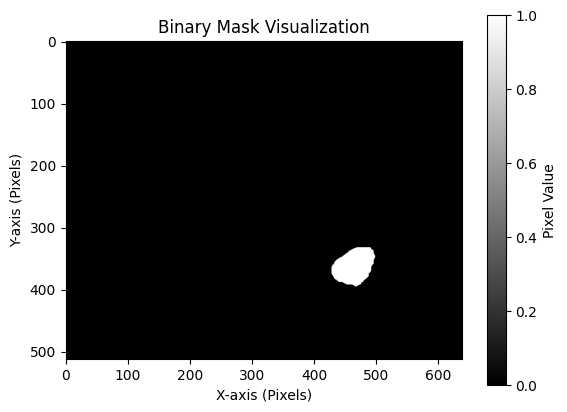

In [20]:
plot_binary_mask(predictions[0][0].masks.masks[1])

In [12]:
predictions[0][0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'head', 1: 'abdomen', 2: 'thorax'}
orig_img: array([[[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [120, 125, 124],
        [120, 125, 124],
        [120, 125, 124]],

       [[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [121, 126, 125],
        [122, 127, 126],
        [122, 127, 126]],

       [[117, 124, 119],
        [117, 124, 119],
        [117, 124, 121],
        ...,
        [120, 125, 124],
        [121, 126, 125],
        [122, 127, 126]],

       ...,

       [[ 82,  87,  86],
        [ 84,  89,  88],
        [ 86,  91,  90],
        ...,
        [ 84,  89,  88],
        [ 85,  90,  89],
        [ 86,  91,  90]],

       [[ 83,  88,  87],
        [ 85,  90,  89],
        [ 87,  92,  91],
        ...,
        [ 83,

In [13]:
import cv2

In [14]:
def plot_segments_from_results(result, return_image:bool=False):
    """
    Plot bounding boxes and segmentation masks using a ultralytics.engine.results.Results object.

    Parameters:
    - result: An instance of ultralytics.engine.results.Results
    """
    # Extracting necessary attributes from the result object
    image = result.orig_img.copy()
    boxes = result.boxes.xyxy
    masks = result.masks.xyn
    cls = result.boxes.cls
    labels = result.names
    conf = result.boxes.conf
    score = True if conf is not None else False

    # Visualize bounding boxes and segmentations
    if return_image:
        image = plot_segments(image, boxes, masks, cls, labels, conf, score, return_image=return_image)
        print("Image type check inside inference_results.py")
        print(type(image))
        return image
    else:
        plot_segments(image, boxes, masks, cls, labels, conf, score, return_image=return_image)

In [15]:
def plot_segments(image, boxes, masks, cls:torch.tensor, labels:dict, conf, score:bool=False, alpha=0.5, return_image:bool=False):
    #colors = color_generator()
    color_lookup = {'head': (0, 255, 0), #green
                    'thorax': (0, 0, 255), #blue
                    'abdomen': (255, 0, 0)} #red
    
    predefined_colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)]
    cls = cls.numpy()
    h, w = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i, (box, mask_points_normalized) in enumerate(zip(boxes, masks)):
        if score:
            label = labels[cls[i]] + " " + str(round(100 * float(conf[i]), 1)) + "%"
        else:
            label = labels.get(cls[i], "Unknown")

        #color = next(colors)
        color = color_lookup[labels.get(cls[i])]
        
        # Draw bounding box
        box_label(image, box, label, color)

        # Denormalize mask points
        mask_points = mask_points_normalized.copy()
        mask_points[:, 0] *= w
        mask_points[:, 1] *= h

        # Convert denormalized mask points to a binary mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [mask_points.astype(np.int32)], 1)

        # Draw segmentation mask
        overlay = image.copy()
        for c in range(3):  # For each RGB channel
            overlay[..., c] = np.where(mask == 1, color[c], overlay[..., c])
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    if return_image:
        return image
    else:
        cv2.imshow('Segments', image)
        cv2.waitKey(0)